# Visualizing SQL Queries

In [1]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(q)
    
def show_tables():
    q_temp = '''
    SELECT name, type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q_temp)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Choosing which genre of music to promote within the USA

Based on the newly produced music albums, the record label and their store partner wish to identify which genres to promote in the USA based on the best selling genres in the country.

The record store is targetting the promotion of 3 albums from a given choice of 4 artists and their corresponding genres.

The artist and their genres are:

| Artist Name |	Genre |
| ----------- | ----- |
|Regal	| Hip-Hop |
|Red Tone |	Punk |
|Meteor and the Girls |	Pop |
|Slim Jim Bites | Blues |

In [3]:
query1 = """
           WITH 
            album_genres AS
            (
                SELECT name, genre_id FROM genre
             ),
             tracks_sold_usa AS
             (
                SELECT invo.* FROM invoice invo
                INNER JOIN invoice_line inv1 ON inv1.invoice_id = invo.invoice_id
                INNER JOIN track tr ON tr.track_id = inv1.track_id
                WHERE invo.billing_country = "USA"
             ),
            buyers AS
            (
                SELECT invoice_id FROM invoice
                WHERE billing_country = "USA"
             )
             
             SELECT t.genre_id Genre_id, ag.name Genre_name, SUM(inv.quantity) Tracks_sold,
             CAST(SUM(inv.quantity) as float)/(SELECT COUNT(*) from tracks_sold_usa) percent_sold
             FROM buyers b 
             INNER JOIN invoice_line inv ON inv.invoice_id = b.invoice_id
             INNER JOIN track t ON t.track_id = inv.track_id
             INNER JOIN album_genres ag ON t.genre_id = ag.genre_id
             GROUP BY 1
             ORDER BY 3 DESC;
         """
album_genres = run_query(query1)

In [4]:
album_genres.set_index("Genre_name",drop=True,inplace=True)
album_genres

,Genre_id,Tracks_sold,percent_sold
Genre_name,,,
Rock,1,561,0.533777
Alternative & Punk,4,130,0.123692
Metal,3,124,0.117983
R&B/Soul,14,53,0.050428
Blues,6,36,0.034253
Alternative,23,35,0.033302
Latin,7,22,0.020932
Pop,9,22,0.020932
Hip Hop/Rap,17,20,0.019029


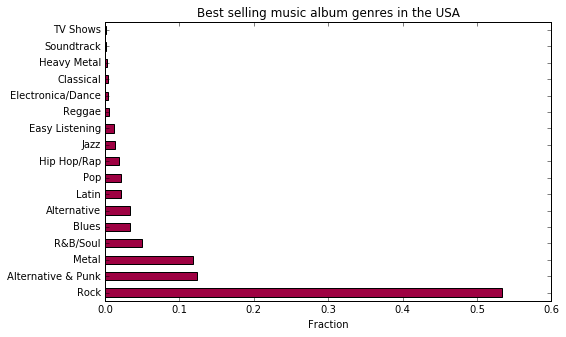

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
cmap = plt.cm.get_cmap('Spectral')
album_genres['percent_sold'].plot(kind='barh', legend = False, ax=ax, colormap=cmap)
plt.title("Best selling music album genres in the USA")
ax.set_xlabel('Fraction')
ax.set_ylabel('')

Using SQL queries we can see visually that "Rock" music has significantly more album sales compared to the other genres. But, none of the available albums are of the "Rock" genre.

Based on the label's albums, the genres "Punk","Blues" and "Pop" would be the best choices to promote via the record store in the USA. The choice to be left out would be "Hip-Hop" since it had the least sales in the USA amongst the 4 choices.

### Comparing sales records of agents

Sales agents employed by the store are assigned to customers to handle and assist the purchase of records. Comparing the sales records of the employed agents alongside pertinent data would assist in highlighting if any internal or external factors played a role in the sales achieved by the agents.

In [6]:
query2 = '''
            WITH 
            agents AS
            (
                SELECT emply.* FROM employee emply
                WHERE title LIKE "%Agent%"
            ),
            employee_sales AS
            (
                SELECT emp.employee_id, SUM(inv.total) Total_Sales
                FROM invoice inv
                INNER JOIN customer c ON c.customer_id = inv.customer_id
                INNER JOIN employee emp ON emp.employee_id = c.support_rep_id
                GROUP BY 1
            )
            
            SELECT ag.first_name || " " || ag.last_name Agent_Name, ag.hire_date Date_of_hire, es.Total_Sales
            FROM agents ag
            INNER JOIN employee_sales es ON es.employee_id = ag.employee_id
            GROUP BY 1
            ORDER BY 2;
            '''

agent_sales = run_query(query2)
agent_sales

,Agent_Name,Date_of_hire,Total_Sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


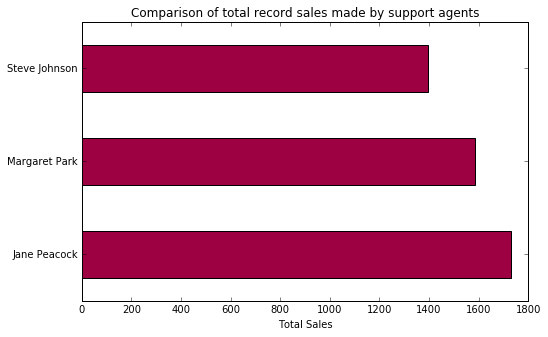

In [7]:
agent_sales.set_index("Agent_Name",drop=True,inplace=True)
fig, ax = plt.subplots(figsize=(8,5))
cmap = plt.cm.get_cmap('Spectral')
agent_sales['Total_Sales'].plot(kind='barh', legend = False, ax=ax, colormap=cmap)
plt.title("Comparison of total record sales made by support agents")
ax.set_xlabel('Total Sales')
ax.set_ylabel('')


Based off the sales data, Jane Peacock achieved the highest sales since being hired by the company and has ~10% more sales than Margaret Park and ~24% more sales than Steve Johnson.

Jane was also the longest tenured amongst the 3 employees, hired roughly 1 month ahead of Margaret and ~6.5 months before Steve. Her being on the job for longer could possibly be the reason behind her superior sales numbers. 

To get a clear picture of who is the best Sales Agent amongst the 3, we should look at their sales data over a fixed and common period of time.

In [8]:
query3 = '''
            WITH 
            global_customer AS
            (
                SELECT c.country Country, COUNT(distinct c.customer_id) No, SUM(inv.total) Total_sales, CAST(SUM(inv.total) as float)/COUNT(c.customer_id) Average_order
                FROM customer c
                INNER JOIN invoice inv ON inv.customer_id = c.customer_id
                GROUP BY 1
                ORDER BY 3 DESC
            ),
            mod_customers AS
            (
                SELECT
                CASE
                    WHEN gc.No > 1 THEN gc.Country
                    WHEN gc.No = 1 THEN "Other"
                END AS Country,
                CASE
                    WHEN gc.No > 1 THEN 1
                    WHEN gc.No = 1 THEN 0
                END AS sort,
                gc.NO Total_customers,
                gc.Total_sales Total_sales_value,
                gc.Average_order Average_order,
                CAST(gc.Total_sales as float)/gc.NO Average_per_customer
                FROM global_customer gc
                
             )
            
            SELECT Country, SUM(Total_customers) Total_Customers, SUM(Total_sales_value) Total_Sales, AVG(Average_order) Average_order_value, AVG(Average_per_customer) Average_per_customer 
            FROM mod_customers
            GROUP BY 1
            ORDER BY sort DESC, Total_sales DESC;
                '''

country_sales = run_query(query3)
country_sales.set_index("Country",drop=True,inplace=True)
country_sales

,Total_Customers,Total_Sales,Average_order_value,Average_per_customer
Country,,,,
USA,13,1040.49,7.942672,80.037692
Canada,8,535.59,7.047237,66.948750
Brazil,5,427.68,7.011148,85.536000
France,5,389.07,7.781400,77.814000
Germany,4,334.62,8.161463,83.655000
Czech Republic,2,273.24,9.108000,136.620000
United Kingdom,3,245.52,8.768571,81.840000
Portugal,2,185.13,6.383793,92.565000
India,2,183.15,8.721429,91.575000


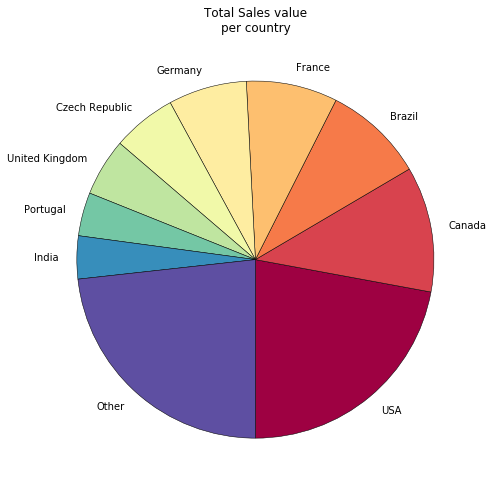

In [9]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1,1,1)

country_sales["Total_Sales"].plot(
    kind="pie",
    ax=ax1,
    startangle=-90,
    title='Total Sales value\nper country',
    colormap=plt.cm.get_cmap('Spectral'),
    wedgeprops={'linewidth':0.5}
);
ax1.set_ylabel('');


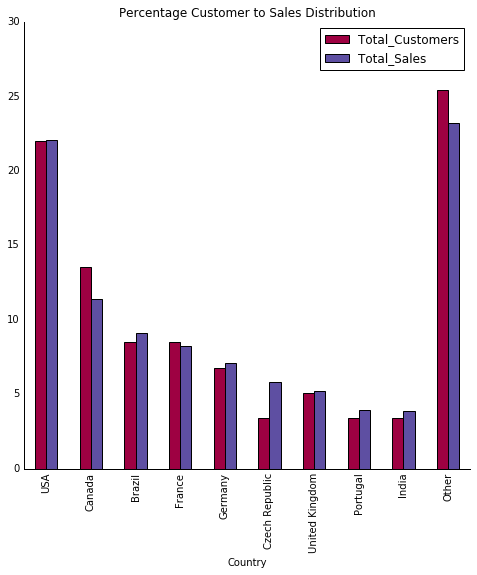

In [10]:
pct_sales = country_sales.iloc[:,0:2]
tot_cust = pct_sales["Total_Customers"].sum()
tot_sale = pct_sales["Total_Sales"].sum()
pct_sales["Total_Customers"] = (pct_sales["Total_Customers"]/tot_cust)*100
pct_sales["Total_Sales"] = (pct_sales["Total_Sales"]/tot_sale)*100

fig = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot(1,1,1)

pct_sales.plot(
    kind="bar",
    ax=ax2,
    title='Percentage Customer to Sales Distribution',
    colormap=plt.cm.get_cmap('Spectral')
);

ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)



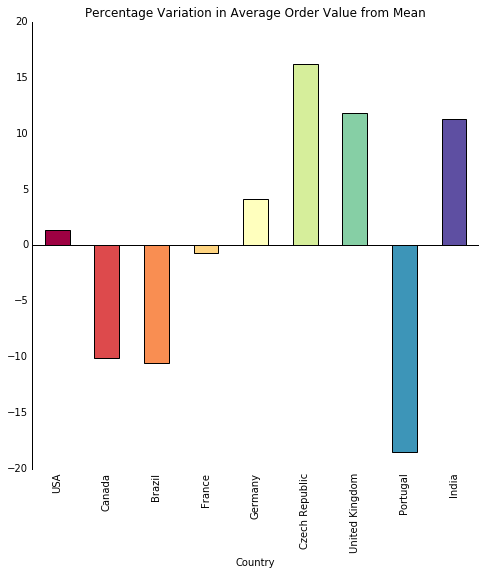

In [11]:
mean_orders = country_sales.iloc[:,2]
mean_orders = ((mean_orders - mean_orders.mean())/mean_orders.mean())*100
mean_orders = mean_orders.drop("Other")

fig = plt.figure(figsize=(8,8))
ax3 = fig.add_subplot(1,1,1)
colors = [plt.cm.Spectral(i) for i in np.linspace(0, 1, mean_orders.shape[0])]

mean_orders.plot(
    kind="bar",
    ax=ax3,
    title='Percentage Variation in Average Order Value from Mean',
    color=colors
);
ax3.axhline(0, color='black')
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)


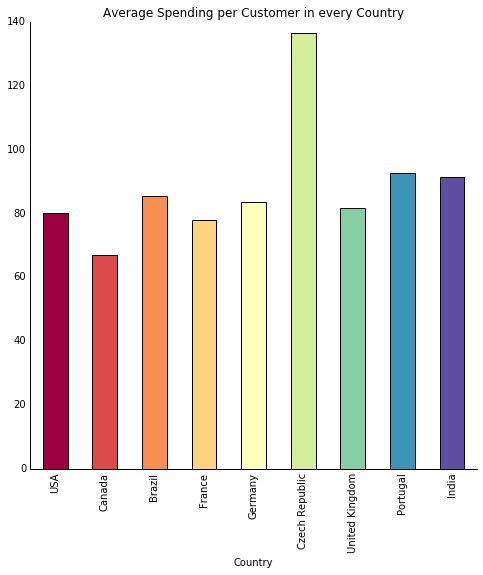

In [12]:
fig = plt.figure(figsize=(8,8))
ax4 = fig.add_subplot(1,1,1)
colors = [plt.cm.Spectral(i) for i in np.linspace(0, 1, mean_orders.shape[0])]
avg_sales = country_sales.drop("Other")

avg_sales["Average_per_customer"].plot(
    kind="bar",
    ax=ax4,
    title='Average Spending per Customer in every Country',
    color=colors
);
ax4.axhline(0, color='black')
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

Based off the above visualizations, 3 countries namely the Czech Republic, India and the United Kingdom are good places to start with improved and increased marketing campaigns. 

Customers from the 3 countries spend more on average than customers from other countries. Their cumulative sales accounted for less than the sales from the USA, increased advertisement campaigns could result in customer growth in those regions.

### Alternate purchase strategy viability

The management team behind the record store are currently considering changing their purchasing strategy to save money and improve their profits.

As it currently stands, the store does not allow customers to purchase a whole album, and then add individual tracks to that same purchase (unless they do that by adding each track manually to their inventory/invoice). There is no price discrepancy when customers choose to purchase the album as a whole or if they had purchased each of the constituent tracks separately.

The new strategy they are considering is to purchase and list for sale only the most popular tracks from each available album from record companies, instead of purchasing every track from an album. They believe this would lead to improved sales as customers are more inclined to purchase popular tracks.

In [85]:
query4 = '''
           WITH invoice_tracks AS
            (
             SELECT
             il.invoice_id invoice_id,
             il.track_id track_id,
             t.album_id album_id,
             inv.total total
             FROM invoice_line il
             INNER JOIN track t ON t.track_id = il.track_id
             INNER JOIN invoice inv ON inv.invoice_id = il.invoice_id
             GROUP BY 1
            ),

                    
            album_purchase AS
            (
             SELECT
              it.*,
              CASE
                  WHEN ( 
                         SELECT at.track_id FROM track at
                         WHERE at.album_id = (SELECT t.album_id FROM track t
                                              WHERE t.track_id = it.track_id)
                         EXCEPT
                         
                         SELECT il.track_id FROM invoice_line il
                         WHERE (il.invoice_id = it.invoice_id)
                       ) IS NULL
                  AND
                       ( 
                         SELECT il.track_id FROM invoice_line il
                         WHERE (il.invoice_id = it.invoice_id)
                         EXCEPT
                         SELECT at.track_id FROM track at
                         WHERE at.album_id = (SELECT t.album_id FROM track t
                                              WHERE t.track_id = it.track_id)
                       ) IS NULL
                THEN "Yes"
                ELSE "No"
              END AS full_album
              FROM invoice_tracks it
              
             )
            
                                             
            SELECT 
            COUNT(ap.invoice_id) No_of_invoices, 
            ap.full_album complete_album,
            CAST(COUNT(ap.invoice_id) as float)/(SELECT COUNT(*) from album_purchase) percentage,
            CAST(SUM(ap.total) as float)/(COUNT (ap.invoice_id)) Average_invoice_value
            FROM album_purchase ap
            GROUP BY 2
            
            
           
'''

run_query(query4)

,No_of_invoices,complete_album,percentage,Average_invoice_value
0,500,No,0.814332,6.496380
1,114,Yes,0.185668,12.817895


Based off the analysis above, More than 80% of the purchases made by customers at the store at are for individual tracks or a collection of individual tracks.

Only ~19% of the purchases made are for complete albums.

If the record store management team were to change and their strategy and eliminate complete album purchasing capability, they would risk alienating ~19% of their customer base who seem to spend on average twice the amount per invoice than the other 81% of customers.